# <center>Exercise 2 Customer Segmentation</center>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans


In [2]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## 1 Business Understanding

Goal:
- Design an optimal distribution strategy.
- Determine appropriate product pricing.
- Develop customized marketing campaigns.

Method:
- Use Kmeans model to help doing business decision.

## 2 Data Understanding

### 2.1 Load data

In [3]:
data = pd.read_csv("customers_segmentation.csv")
data

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


### 2.2 Clean Data
- Check any missing values
- Check any duplicated
- Check any outliers

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


> Notes:
> - This customer sample size is 200.
> - There is no missing values.

**Check any duplicated records**

In [5]:
data[data.duplicated() == True]

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)


> Notes:
> - There is no duplicated records.

**Check any outliers**

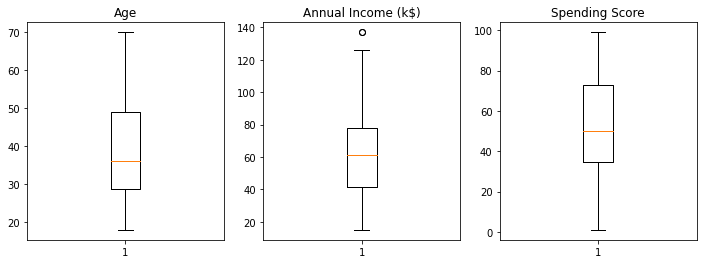

In [6]:
# Visualize any outliers by scatter plot
fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].boxplot(data['Age'])
axs[0].set_title('Age')
axs[1].boxplot(data['Annual Income (k$)'])
axs[1].set_title('Annual Income (k$)')
axs[2].boxplot(data['Spending Score (1-100)'])
axs[2].set_title('Spending Score')

plt.show()

>Notes:
> - There is an outlier in Annual Income data.

**Capture this outlier.**

In [7]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


>Notes:
>- The outlier in Annual Income data should be 137(the max value).

**Remove the outlier**

In [8]:
data[data['Annual Income (k$)'] == 137]

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
198,199,Male,32,137,18
199,200,Male,30,137,83


In [9]:
data = data[data['Annual Income (k$)'] < 137]
data

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
193,194,Female,38,113,91
194,195,Female,47,120,16
195,196,Female,35,120,79
196,197,Female,45,126,28


>Notes:
>- The number of records is changed to 198 after outlier being removed.

### 2.3 Exploratory Data Analysis

#### (1) Visualize data distribution

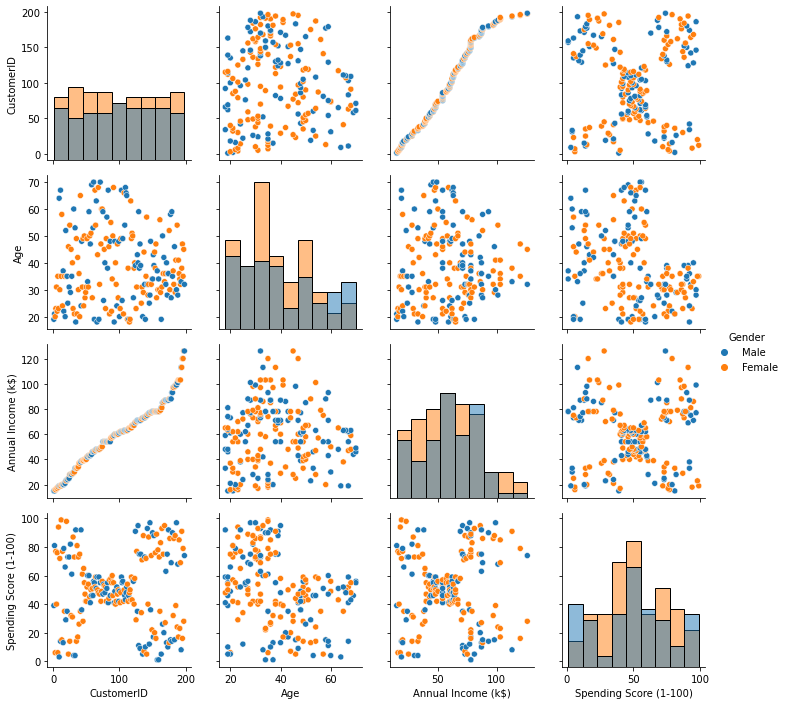

In [10]:
g = sns.PairGrid(data, hue="Gender")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()


**(2) Visualize the percentage of gender**

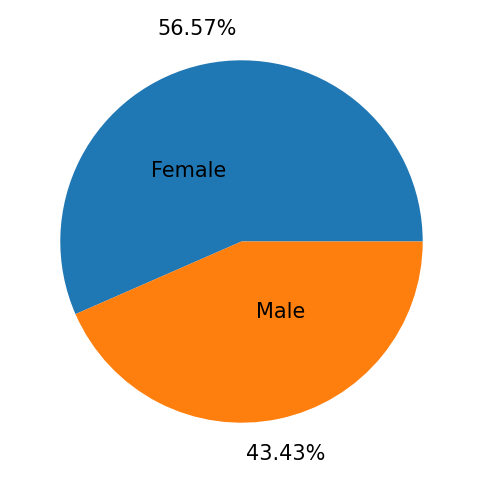

In [11]:
sizes = data.Gender.value_counts()
labels = list(data.Gender.value_counts().index)

fig, ax = plt.subplots(dpi=150)
ax.pie(sizes, labels=labels, autopct='%1.2f%%',
       pctdistance=1.2, labeldistance=.4)
plt.show()

>Notes:
>- Female customers are more than male customers.
>- Young adults and middle-age people are the major customers.
>- Annual Income data is right skewed.So its median is greater than its mean.
>- Spending Score data is closed to normal, and the mean/median is around 50.

**(3) Check the correlation amongst the features**

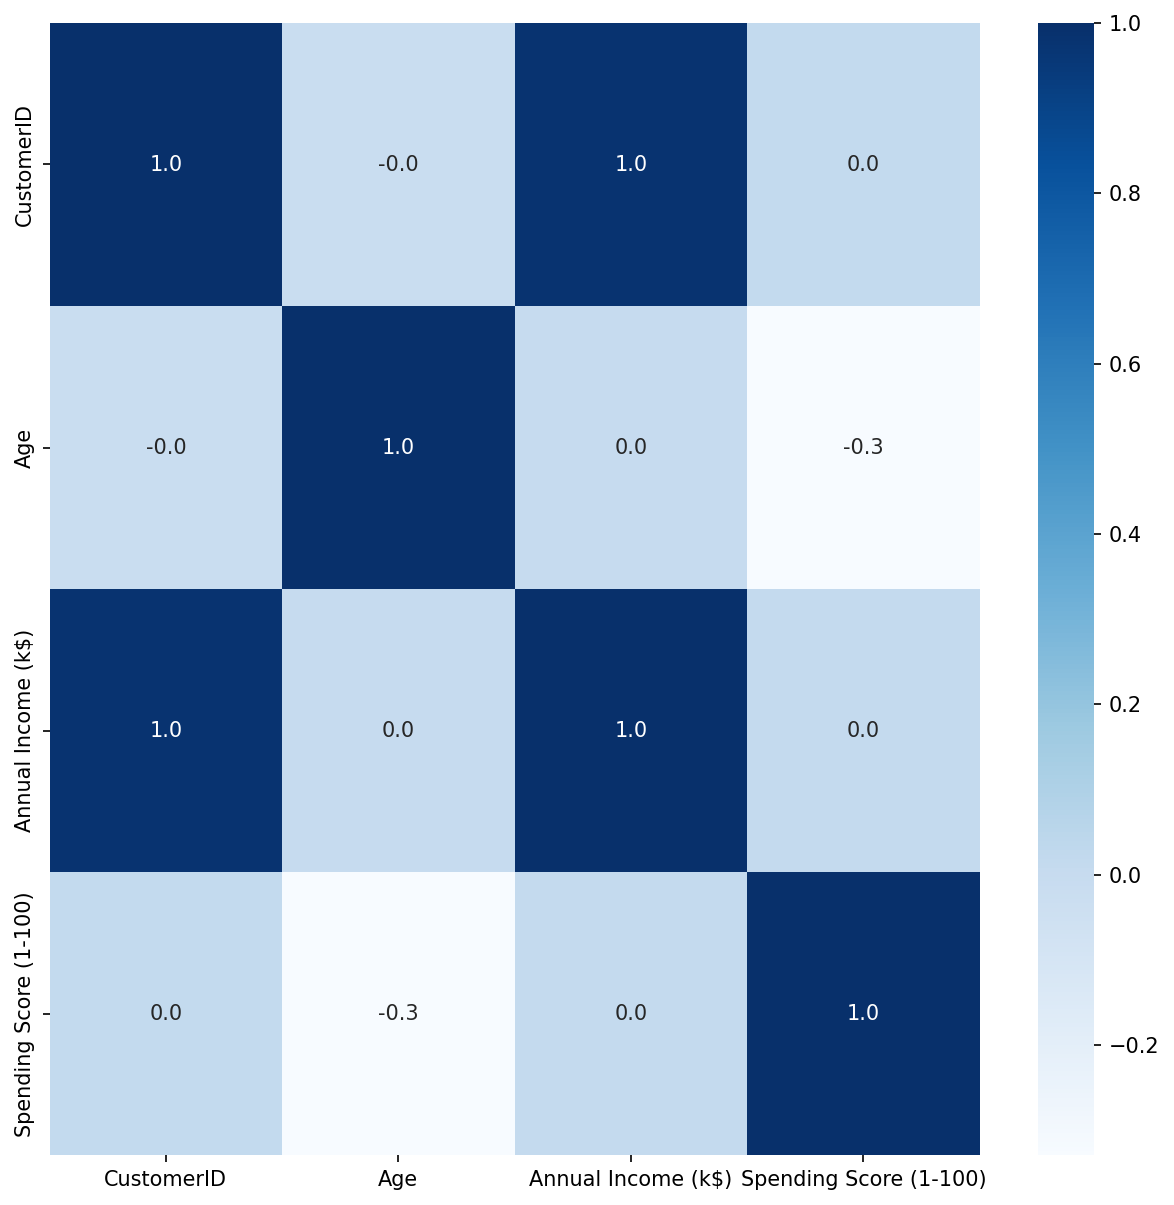

In [12]:
correlation_matrix = data.corr()
plt.figure(figsize=(10,10), dpi=150)
sns.heatmap(correlation_matrix, cbar=True, fmt='.1f', annot=True, cmap='Blues')
plt.show()
#plt.savefig('Correlation Heat Map')

>Notes:
>- It is shown that there is slight negative correlation between Age and Spending.

**(4) Visualize the spending score distribution**

Data preprocessing - Remove customer ID column

In [13]:
data.drop('CustomerID', axis=1, inplace=True)
data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


Data preprocessing - Use the LabelEncoder to encode gender from male and female to 1 and 0

In [14]:
encoder = LabelEncoder()  # Name LabelEncoder functions as encoder
data['Gender'] = encoder.fit_transform(data['Gender'])  # Transform 'Gender' column of data to 1 and 0.
data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


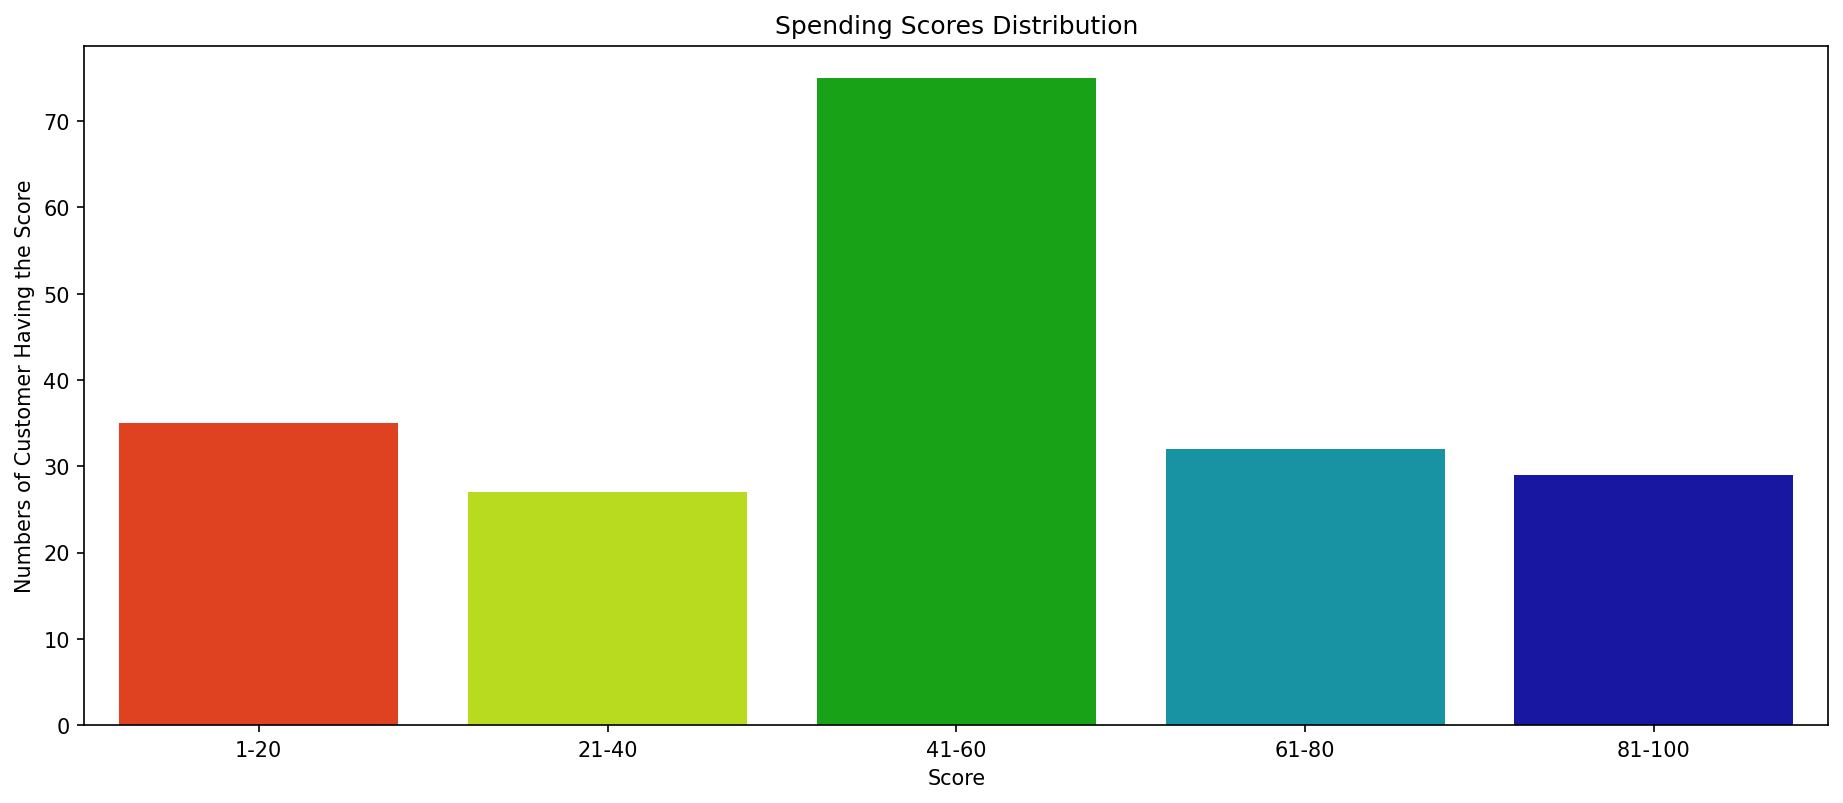

In [15]:
# Define the spending score range and its corresponding value
ss1_20 = data["Spending Score (1-100)"][(data["Spending Score (1-100)"] >= 1) & (data["Spending Score (1-100)"] <= 20)]
ss21_40 = data["Spending Score (1-100)"][(data["Spending Score (1-100)"] >= 21) & (data["Spending Score (1-100)"] <= 40)]
ss41_60 = data["Spending Score (1-100)"][(data["Spending Score (1-100)"] >= 41) & (data["Spending Score (1-100)"] <= 60)]
ss61_80 = data["Spending Score (1-100)"][(data["Spending Score (1-100)"] >= 61) & (data["Spending Score (1-100)"] <= 80)]
ss81_100 = data["Spending Score (1-100)"][(data["Spending Score (1-100)"] >= 81) & (data["Spending Score (1-100)"] <= 100)]

# Define the X and Y axis label and value 
ssx = ["1-20", "21-40", "41-60", "61-80", "81-100"]
ssy = [len(ss1_20.values), len(ss21_40.values), len(ss41_60.values), len(ss61_80.values), len(ss81_100.values)]

# Plot the visualization
plt.figure(figsize=(15,6), dpi=150) 
sns.barplot(x=ssx, y=ssy, palette="nipy_spectral_r") # Define the bar chart value
plt.title("Spending Scores Distribution") 
plt.xlabel("Score")  
plt.ylabel("Numbers of Customer Having the Score")  
plt.show() 

>Note:
>- The spending score 41-60 got the most numbers of customers.

**(5) Visulize the Customer Distribution in 3D Diagram**
(Age, Annual Income and Spending Score(1-100))

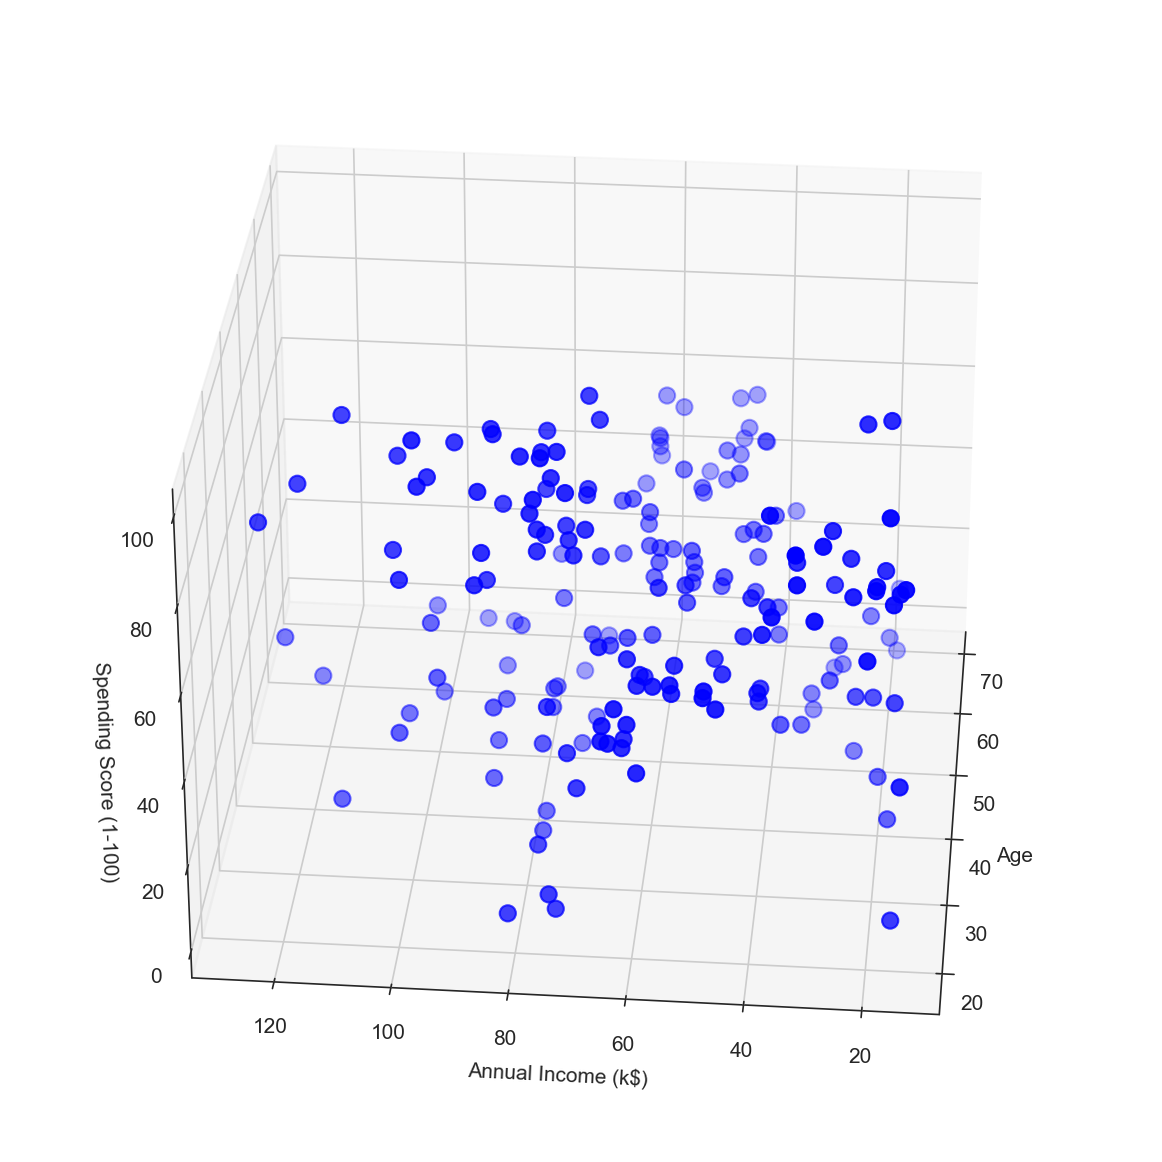

In [16]:
sns.set_style('white')
fig = plt.figure(figsize=(20,10), dpi=150)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data['Age'], data['Annual Income (k$)'], data['Spending Score (1-100)'], c='blue', s=60)
ax.view_init(30, 185)
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
plt.show()

## 3 Data Preparation

### 3.1 Scale Data by StandardScaler
(Standardize features by removing the mean and scaling to unit variance)

In [17]:
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
scaled_data

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1.141195,-1.425414,-1.779171,-0.435989
1,1.141195,-1.282367,-1.779171,1.199413
2,-0.876275,-1.353890,-1.739447,-1.720949
3,-0.876275,-1.139319,-1.739447,1.043661
4,-0.876275,-0.567131,-1.699723,-0.397051
...,...,...,...,...
193,-0.876275,-0.066466,2.113819,1.588795
194,-0.876275,0.577246,2.391890,-1.331567
195,-0.876275,-0.281037,2.391890,1.121537
196,-0.876275,0.434198,2.630236,-0.864309


### 3.2 Find Out Optimal Number of K

#### 3.2.1 The Elbow method

Calculate the Within-Cluster-Sum of Squared Errors (WSS) for different values of k, and choose the k for which WSS becomes first starts to diminish. Capture the optimal K from the plot of WSS-versus-k which is visible as an elbow.

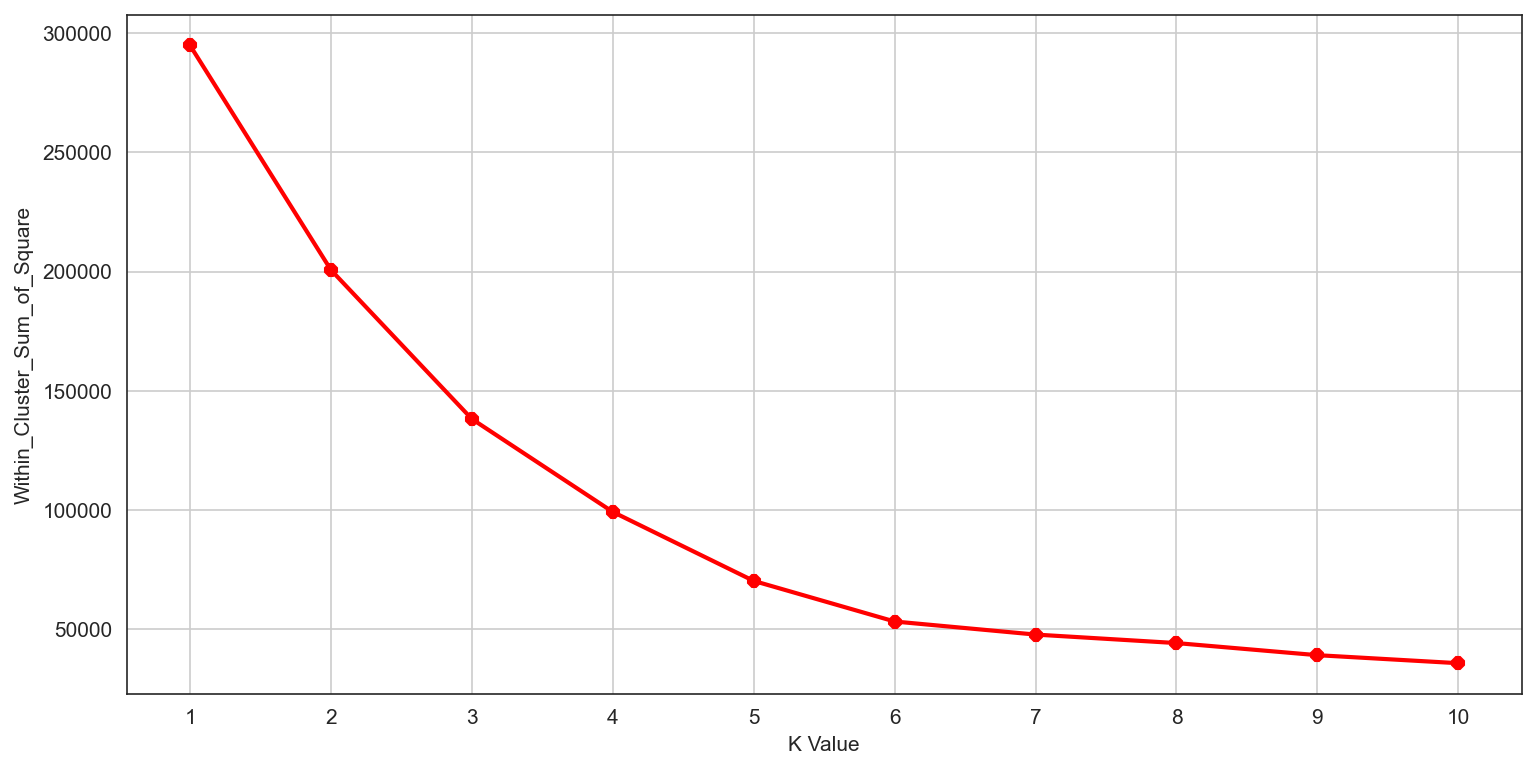

In [18]:
Within_Cluster_Sum_of_Square = []
kmax = 10

for k in range(1,kmax+1):
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans.fit(data)
    Within_Cluster_Sum_of_Square.append(kmeans.inertia_)

    
plt.figure(figsize=(12,6), dpi=150)

plt.plot(range(1,kmax+1), Within_Cluster_Sum_of_Square, linewidth=2, color='red', marker='8')
plt.xlabel('K Value')
plt.xticks(np.arange(1,kmax+1,1))
plt.ylabel('Within_Cluster_Sum_of_Square')

plt.grid()
plt.show()

#### 3.2.2 The Silhouette Method

The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation).

The range of the Silhouette value is between +1 and -1. A high value is desirable and indicates that the point is placed in the correct cluster. If many points have a negative Silhouette value, it may indicate that we have created too many or too few clusters.

Source: Wikipedia

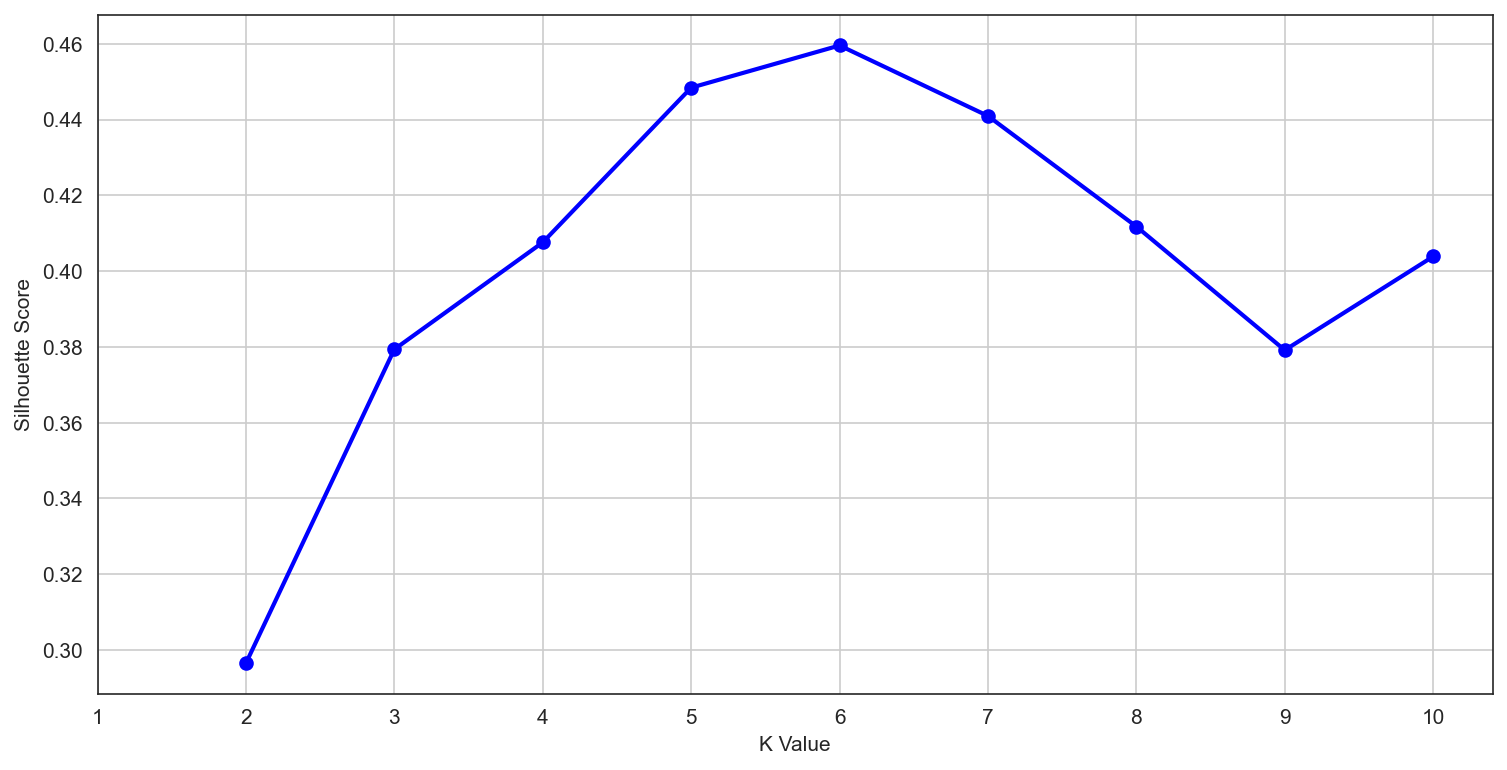

In [19]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(data)
  labels = kmeans.labels_
  sil.append(silhouette_score(data, labels, metric = 'euclidean'))


plt.figure(figsize=(12,6), dpi=150)

plt.plot(range(2, kmax+1), sil, linewidth=2, color='blue', marker='o')
plt.xlabel('K Value')
plt.xticks(np.arange(1,kmax+1,1))
plt.ylabel('Silhouette Score')

plt.grid()
plt.show()

>Notes:
>- Based on the two methods, will take 6 as K value.

## 4 Modeling

In [20]:
# Define model
km = KMeans(n_clusters=6, n_init=5)

# Run model
clusters = km.fit_predict(data)
data['label'] = clusters

data

,Gender,Age,Annual Income (k$),Spending Score (1-100),label
0,1,19,15,39,4
1,1,21,15,81,5
2,0,20,16,6,4
3,0,23,16,77,5
4,0,31,17,40,4
...,...,...,...,...,...
193,0,38,113,91,1
194,0,47,120,16,2
195,0,35,120,79,1
196,0,45,126,28,2


##  5 Descriptive Data Analytics of Each Cluster

### 5.1 Visualize Customer Distribution in Each Cluster by Pie Chart

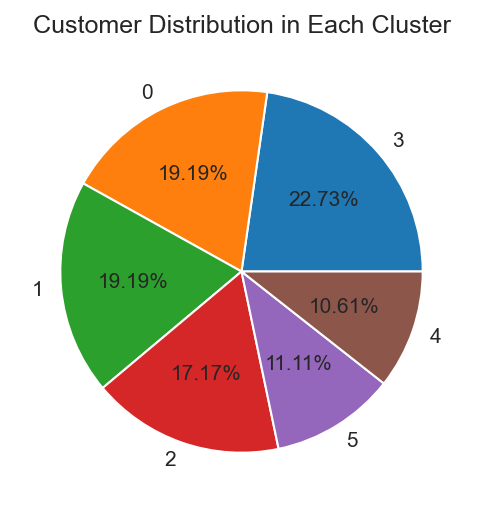

In [21]:
sizes = data.label.value_counts()
labels = list(data.label.value_counts().index)

plt.figure(dpi=150)
plt.pie(sizes, labels=labels, autopct='%4.2f%%')
plt.title('Customer Distribution in Each Cluster')
plt.show()

### 5.2 Visualize Clusters Profile Based on Annual Income and Spending Score

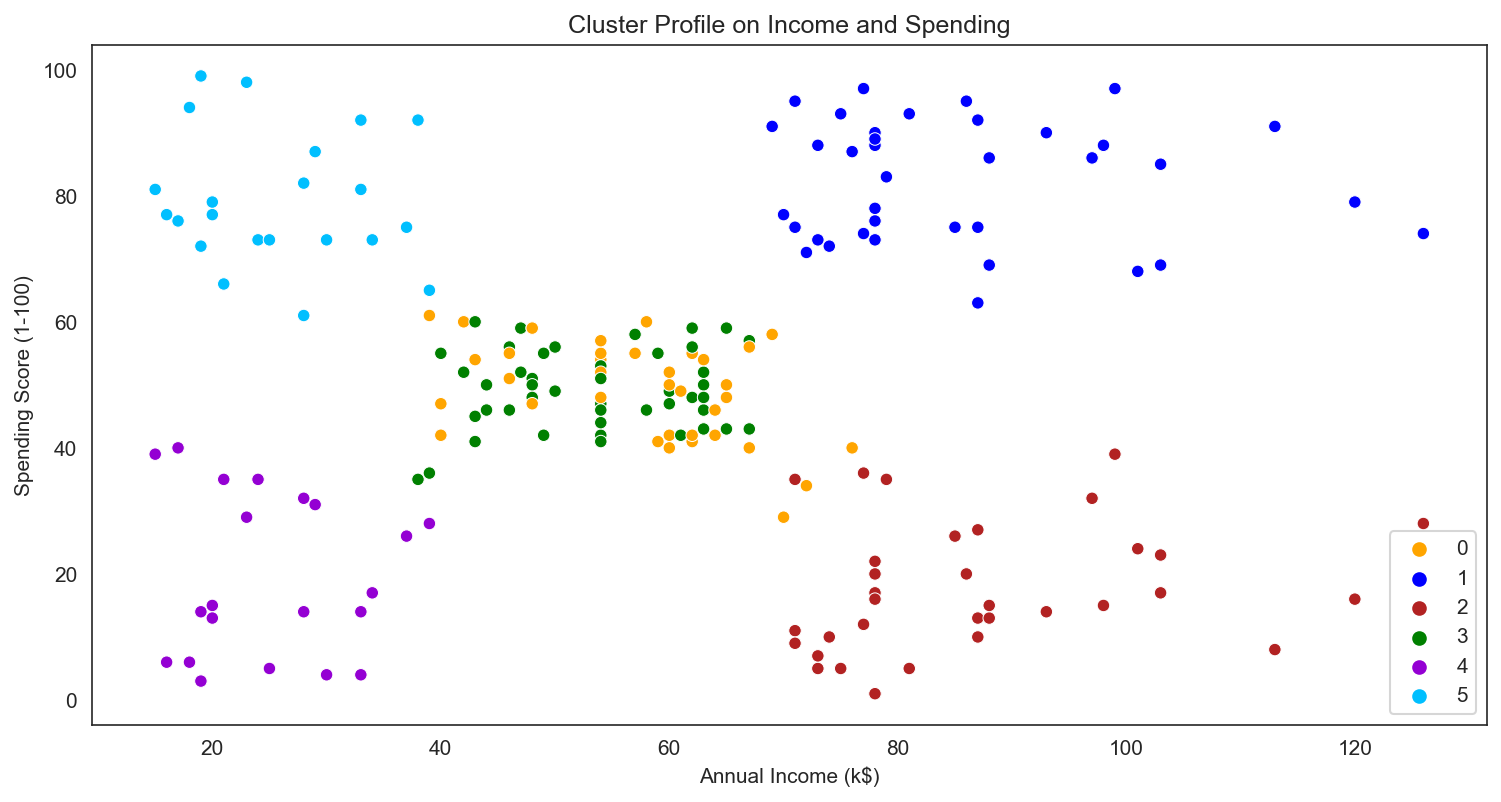

In [22]:
plt.figure(figsize=(12,6), dpi=150)
pal = ['orange', 'blue', 'firebrick', 'green', 'darkviolet', 'deepskyblue']
pl = sns.scatterplot(data=data, x=data['Annual Income (k$)'], y=data['Spending Score (1-100)'], hue=data['label'], palette=pal)
pl.set_title('Cluster Profile on Income and Spending')
plt.legend()
plt.show()

### 5.3 Visualize Customers Distribution in Each Cluster in 3D Diagram
(Age, Annual Income and Spending Score(1-100))

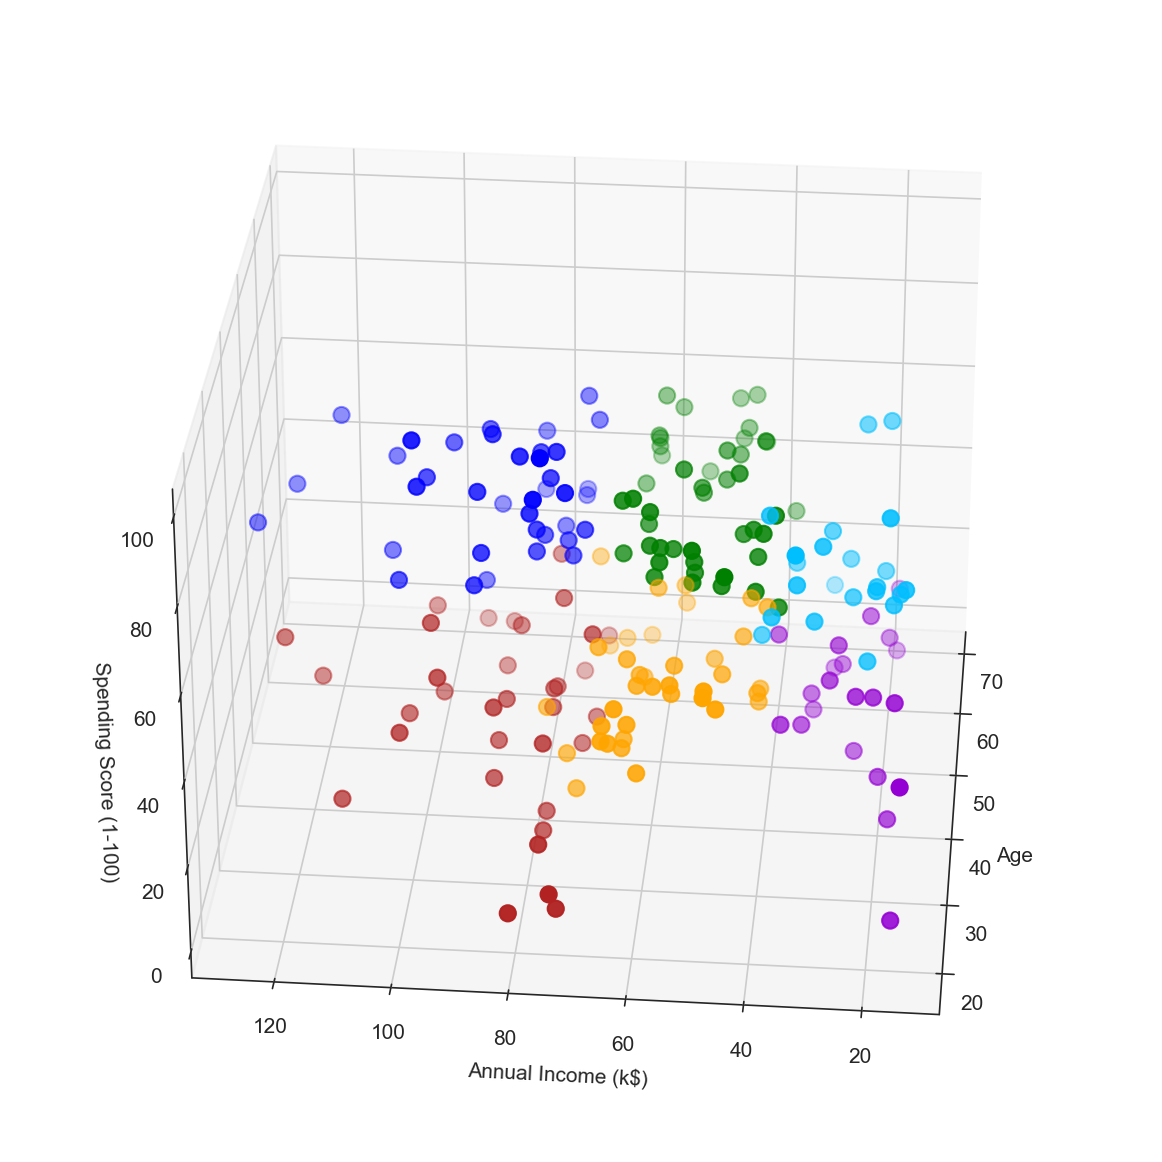

In [23]:
fig = plt.figure(figsize=(20,10), dpi=150)
ax = fig.add_subplot(111,projection='3d')
ax.scatter(data["Age"][data.label == 0], data["Annual Income (k$)"][data.label == 0], data["Spending Score (1-100)"][data.label == 0], c='orange', s=60)
ax.scatter(data["Age"][data.label == 1], data["Annual Income (k$)"][data.label == 1], data["Spending Score (1-100)"][data.label == 1], c='blue', s=60)
ax.scatter(data["Age"][data.label == 2], data["Annual Income (k$)"][data.label == 2], data["Spending Score (1-100)"][data.label == 2], c='firebrick', s=60)
ax.scatter(data["Age"][data.label == 3], data["Annual Income (k$)"][data.label == 3], data["Spending Score (1-100)"][data.label == 3], c='green', s=60)
ax.scatter(data["Age"][data.label == 4], data["Annual Income (k$)"][data.label == 4], data["Spending Score (1-100)"][data.label == 4], c='darkviolet', s=60)
ax.scatter(data["Age"][data.label == 5], data["Annual Income (k$)"][data.label == 5], data["Spending Score (1-100)"][data.label == 5], c='deepskyblue', s=60)

ax.view_init(30, 185)
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
ax.set_zlabel('Spending Score (1-100)')
plt.show()

### 5.4 Visualize Each Feature Mean Value in Each Cluster

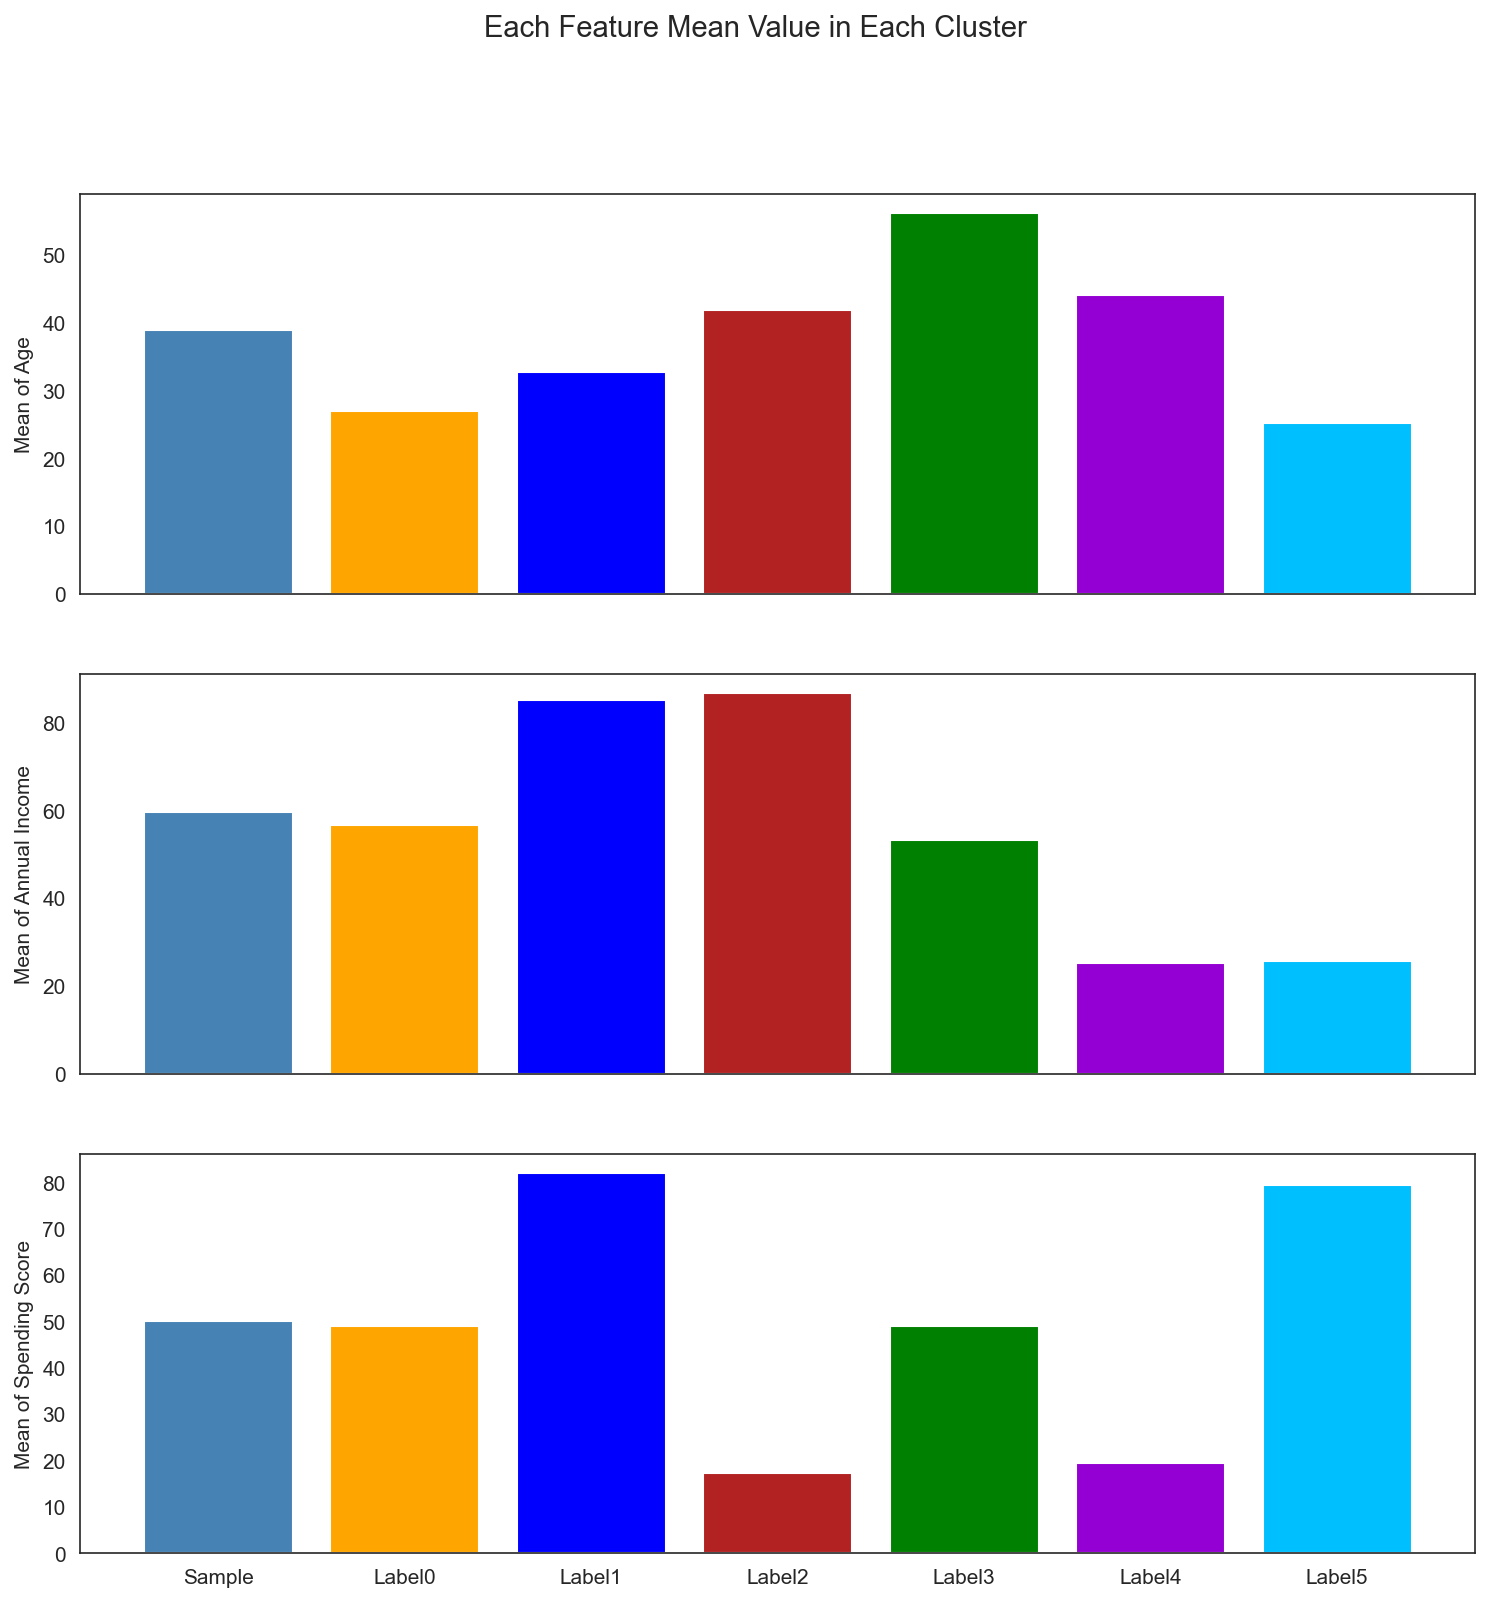

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12,12), dpi=150)
fig.suptitle('Each Feature Mean Value in Each Cluster', fontsize=14)
colors = ['steelblue', 'orange', 'blue', 'firebrick', 'green', 'darkviolet', 'deepskyblue']

x = ['Sample','Label0','Label1','Label2','Label3', 'Label4', 'Label5']

# Mean of Age: Each Cluster vs. Sample
age_y = [(data.Age.mean()),(data[data.label == 0].Age.mean()), (data[data.label == 1].Age.mean()), 
         (data[data.label == 2].Age.mean()), (data[data.label == 3].Age.mean()),
         (data[data.label == 4].Age.mean()), (data[data.label == 5].Age.mean())]
ax1.bar(x, age_y, color=colors)
ax1.set_ylabel('Mean of Age')


# Mean of Annual Income: Each Cluster vs. Sample
ai_y = [(data['Annual Income (k$)'].mean()),(data[data.label == 0]['Annual Income (k$)'].mean()), (data[data.label == 1]['Annual Income (k$)'].mean()), 
        (data[data.label == 2]['Annual Income (k$)'].mean()), (data[data.label == 3]['Annual Income (k$)'].mean()),
        (data[data.label == 4]['Annual Income (k$)'].mean()), (data[data.label == 5]['Annual Income (k$)'].mean())]
ax2.bar(x, ai_y, color=colors)
ax2.set_ylabel('Mean of Annual Income')


# Mean of Spending Score: Each Cluster vs. Sample
ss_y = [(data['Spending Score (1-100)'].mean()),(data[data.label == 0]['Spending Score (1-100)'].mean()), (data[data.label == 1]['Spending Score (1-100)'].mean()), 
        (data[data.label == 2]['Spending Score (1-100)'].mean()), (data[data.label == 3]['Spending Score (1-100)'].mean()),
        (data[data.label == 4]['Spending Score (1-100)'].mean()), (data[data.label == 5]['Spending Score (1-100)'].mean())]
ax3.bar(x, ss_y, color=colors)
ax3.set_ylabel('Mean of Spending Score')

plt.show()

**Cluster 1, label is 0.**

In [25]:
data[data.label == 0].describe()

,Gender,Age,Annual Income (k$),Spending Score (1-100),label
count,38.000000,38.000000,38.000000,38.000000,38.0
mean,0.342105,27.000000,56.657895,49.131579,0.0
std,0.480783,7.032742,9.905708,7.853975,0.0
min,0.000000,18.000000,39.000000,29.000000,0.0
25%,0.000000,21.000000,48.000000,42.000000,0.0
50%,0.000000,26.500000,59.500000,50.000000,0.0
75%,1.000000,31.750000,63.750000,55.000000,0.0
max,1.000000,40.000000,76.000000,61.000000,0.0


**Cluster 2, label is 1.**

In [26]:
data[data.label == 1].describe()

,Gender,Age,Annual Income (k$),Spending Score (1-100),label
count,38.000000,38.000000,38.000000,38.000000,38.0
mean,0.447368,32.763158,85.210526,82.105263,1.0
std,0.503897,3.752003,14.235771,9.489082,0.0
min,0.000000,27.000000,69.000000,63.000000,1.0
25%,0.000000,30.000000,75.250000,74.250000,1.0
50%,0.000000,32.000000,78.500000,84.000000,1.0
75%,1.000000,35.750000,91.750000,90.000000,1.0
max,1.000000,40.000000,126.000000,97.000000,1.0


**Cluster 3, label is 2.**

In [27]:
data[data.label == 2].describe()

,Gender,Age,Annual Income (k$),Spending Score (1-100),label
count,34.000000,34.000000,34.000000,34.000000,34.0
mean,0.558824,41.970588,86.794118,17.264706,2.0
std,0.503995,10.928099,14.205802,10.364008,0.0
min,0.000000,19.000000,71.000000,1.000000,2.0
25%,0.000000,36.000000,77.250000,10.000000,2.0
50%,1.000000,43.000000,83.000000,15.500000,2.0
75%,1.000000,47.750000,96.000000,23.750000,2.0
max,1.000000,59.000000,126.000000,39.000000,2.0


**Cluster 4, label is 3.**

In [28]:
data[data.label == 3].describe()

,Gender,Age,Annual Income (k$),Spending Score (1-100),label
count,45.000000,45.000000,45.000000,45.000000,45.0
mean,0.444444,56.155556,53.377778,49.088889,3.0
std,0.502519,8.543886,8.435016,6.251626,0.0
min,0.000000,43.000000,38.000000,35.000000,3.0
25%,0.000000,49.000000,47.000000,45.000000,3.0
50%,0.000000,54.000000,54.000000,49.000000,3.0
75%,1.000000,65.000000,62.000000,55.000000,3.0
max,1.000000,70.000000,67.000000,60.000000,3.0


**Cluster 5, label is 4.**

In [29]:
data[data.label == 4].describe()

,Gender,Age,Annual Income (k$),Spending Score (1-100),label
count,21.000000,21.000000,21.000000,21.000000,21.0
mean,0.380952,44.142857,25.142857,19.523810,4.0
std,0.497613,13.089254,7.226934,12.769569,0.0
min,0.000000,19.000000,15.000000,3.000000,4.0
25%,0.000000,35.000000,19.000000,6.000000,4.0
50%,0.000000,45.000000,24.000000,15.000000,4.0
75%,1.000000,53.000000,30.000000,31.000000,4.0
max,1.000000,67.000000,39.000000,40.000000,4.0


**Cluster 6, label is 5.**

In [30]:
data[data.label == 5].describe()

,Gender,Age,Annual Income (k$),Spending Score (1-100),label
count,22.000000,22.000000,22.000000,22.000000,22.0
mean,0.409091,25.272727,25.727273,79.363636,5.0
std,0.503236,5.257030,7.566731,10.504174,0.0
min,0.000000,18.000000,15.000000,61.000000,5.0
25%,0.000000,21.250000,19.250000,73.000000,5.0
50%,0.000000,23.500000,24.500000,77.000000,5.0
75%,1.000000,29.750000,32.250000,85.750000,5.0
max,1.000000,35.000000,39.000000,99.000000,5.0


## 6 Findings and Business Suggestions

1. Customer
- Female customers are more than male customers.
- Young adults and middle-age people are major customers.
- So, most of the items sold should satisfy the needs of these customers.
- And Ecommerce APP should be well developed and is encouraged to be installed for them to place orders any time any where.

2. Pricing
- In general, 30% customers purchasing power are above the average; 30% customers purchasing power are less the average; and 40% customers purchasing power are about the average. To satisfiy this ratio of purchasing power, the price of items sold in this supermarket should be allocated following this ratio.

3. Business suggestions for each cluster
(XXXXX)